# Objective

The objective of this notebook is to implement Principal Component Analysis (PCA) and Dual PCA on the CIFAR-10 dataset and compare their computational efficiency by measuring the time taken to compute the principal components.

# Dataset Preparation

To implement PCA and Dual PCA, we will be using `numpy`. For visualizations of the results of PCA and Dual PCA, we use `matplotlib`. The CIFAR-10 dataset will be loaded in via the `torchvision` library.

The CIFAR-10 dataset contains 32x32 color images from 10 classes. There are 50,000 training images and 10,000 test images.

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# transform to torch.Tensor to later transform to numpy arrays
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load CIFAR-10
training_data = datasets.CIFAR10(
    root="CIFAR-10",
    train=True,
    download=True,
    transform=tensor_transform
)

Files already downloaded and verified


In [2]:
# transform images from tensors to numpy
images = np.array([np.array(image[0]) for image in training_data])

images.shape

(50000, 3, 32, 32)

Now that we loaded the CIFAR-10 dataset, we will center the data by subtracing the mean from each feature. However, we first need to shape the data from a tensor into a matrix. The tensor currently has dimension $N\times C\times D \times D$, where $N$ is the number of data points, $C$ is the number of color channels, and $D$ is the dimension of the image. To turn this into a matrix, we combine the final three dimensions into a single dimension: $$N\times C \times D\times D \implies (CD^2)\times N$$

This gives us matrix $X \in \mathbb{R}^{d\times n}$. We let numpy handle reshaping by using `numpy.reshape`.

In [3]:
N, C, D, _ = images.shape

images = np.reshape(images, (N, C * D * D)) # reshape first, then transpose to maintain data order
images = images.T
images.shape

(3072, 50000)

# PCA Implementation

Standard PCA requires us to compute the covariance matrix of our dataset $X\in\mathbb{R}^{d\times n}$, where $d$ is the number of features and $n$ is the number of datapoints. We compute the covariance matrix as follows:
$$C=\frac{1}{n-1}XX^T$$
First, we need to centralize the data by subtracting the mean of each feature. Then, we use the formula above to find the covariance matrix.

In [4]:
# get mean of each feature and subtract
X = images - np.mean(images, axis=1)[:,None] # None used to create axis to broadcast (taken from numpy.cov)

C = X @ X.T / (N - 1)

Now, we perform the eigenvalue decomposition on the covariance matrix to obtain the principal components. For this we use `numpy.linalg.eig`.

In [5]:
# find eigendecomposition
eigvals, eigvecs = np.linalg.eig(C)

# we sort the eigenvectors by the eigenvalues to order the principal components
idx = np.argsort(-eigvals, axis=0)
PCvals = eigvals[idx]
PCvecs = eigvecs[:, idx]

Let's implement this as a function from start to finish to profile the performance of later.

In [6]:
def pca(images, num_images):
    # construct matrix X and centralize
    X = images[:,:num_images]
    X = X - np.mean(X, axis=1)[:,None]

    # compute the covariance matrix
    C = X @ X.T / (num_images - 1)
    
    # perform eigenvalue decomposition and sort by principal components
    eigvals, eigvecs = np.linalg.eig(C)
    idx = np.argsort(-eigvals, axis=0)
    PCvals = eigvals[idx]
    PCvecs = eigvecs[:, idx]
    
    return PCvals, PCvecs

# Dual PCA Implementation

To compute the dual PCA, we use the same matrix $X$, but subtract the mean from each data point instead. Then, we compute the Gram matrix $G$:
$$G=\frac{1}{n-1}X^TX$$
Then, we perform eigenvalue decomposition on the $n\times n$ Gram matrix to find the principal components.

In [7]:
X = images - np.mean(images, axis=0)
X = X[:,:5000]

G = X.T @ X / (4999)

Then, we perform eigenvalue decomposition to obtain the principal components. Note that the encoding and reconstruction of training data is different than with standard PCA.

## Encoding

We encode the training data by first calculating the Gram matrix and finding the eigenvalue decomposition. Then, $V\in\mathbb{R}^{n\times p}$ is the matrix of the top $p$ eigenvectors of $G$ and $\Sigma\in\mathbb{R}^{p\times p}$ is a diagonal matrix of the square roots of the top $p$ eigenvalues. The encoding of the data $Y\in\mathbb{R}^{p\times n}$ is:

$$Y = \Sigma V^T$$

For an individual test sample, we can get a $p$-dimensional encoding $\mathbf{y}$ of $\mathbf{x}$:

$$\mathbf{y} = \Sigma^{-1}V^TX^T\mathbf{x}$$

## Reconstruction

The reconstructed training data $\hat X\in\mathbb{R}^{d\times n}$ can be obtained as shown:

$$\hat X = XVV^T$$

To reconstruct a test sample $\hat{\mathbf{x}}$, we use the formula below:

$$\hat{\mathbf{x}} = XV\Sigma^{-2}V^TX^T\mathbf{x}$$

In [8]:
eigvals, eigvecs = np.linalg.eig(G)

idx = np.argsort(-eigvals, axis=0)
DPCvals = eigvals[idx]
DPCvecs = eigvecs[:, idx]

From the cell execution times above, we can see that the dual PCA algorithm took much longer to run in compairson to the standard PCA implementation. This is because we are doing a matrix multiplication along the larger dimension ($n > d$). In addition, the large result (50000 x 50000 for the full dataset) cannot fit within most memory sizes, also making computation difficult. Therefore, we reduce the dataset to the first 5000 images in this example.

We will implement a function to find the relevant Dual PCA vectors for further profiling.

In [9]:
def dual_pca(images, num_images):
    # construct matrix X and centralize
    X = images[:,:num_images]
    X = X - np.mean(X, axis=1)[:,None]

    # compute the Gram matrix
    G = X.T @ X / (num_images - 1)
    
    # perform eigenvalue decomposition and sort by principal components
    eigvals, eigvecs = np.linalg.eig(G)
    idx = np.argsort(-eigvals, axis=0)
    PCvals = eigvals[idx]
    PCvecs = eigvecs[:, idx]
    
    return DPCvals, DPCvecs

# Methods Comparison

We will measure the time taken to get principal components by PCA and Dual PCA on the CIFAR-10 dataset, recording for different data sizes/dimensions.

Below we have a series of dataset sizes to test, and we take the first $n$ images in each case for PCA.

In [10]:
import time

# different choices of n to test
pca_image_sizes = [100, 500, 1000, 2500, 5000, 10000, 20000, 30000, 40000, 50000]
pca_time_taken = {}

# time all configurations of n
for size in pca_image_sizes:
    start_time = time.time()
    pca(images, size)
    end_time = time.time()
    pca_time_taken[size] = end_time - start_time

for size, duration in pca_time_taken.items():
    print(f"Time taken for PCA with {size} images: {duration:.4f} seconds") 

Time taken for PCA with 100 images: 30.5286 seconds
Time taken for PCA with 500 images: 27.9196 seconds
Time taken for PCA with 1000 images: 24.4410 seconds
Time taken for PCA with 2500 images: 22.2044 seconds
Time taken for PCA with 5000 images: 24.0145 seconds
Time taken for PCA with 10000 images: 24.5102 seconds
Time taken for PCA with 20000 images: 25.3693 seconds
Time taken for PCA with 30000 images: 26.5230 seconds
Time taken for PCA with 40000 images: 27.4280 seconds
Time taken for PCA with 50000 images: 27.3944 seconds


In [11]:
# only time up to n = 10000 images to avoid costly computation and OOM error
dpca_image_sizes = [100, 500, 1000, 2500, 5000, 10000]
dpca_time_taken = {}

for size in dpca_image_sizes:
    start_time = time.time()
    dual_pca(images, size)
    end_time = time.time()
    dpca_time_taken[size] = end_time - start_time

for size, duration in dpca_time_taken.items():
    print(f"Time taken for Dual PCA with {size} images: {duration:.4f} seconds") 

Time taken for Dual PCA with 100 images: 0.0215 seconds
Time taken for Dual PCA with 500 images: 0.5890 seconds
Time taken for Dual PCA with 1000 images: 1.8850 seconds
Time taken for Dual PCA with 2500 images: 10.8569 seconds
Time taken for Dual PCA with 5000 images: 57.1203 seconds
Time taken for Dual PCA with 10000 images: 343.6070 seconds


We can see that the time for the PCA algorithm remains constant, while the Dual PCA time increases polynomially. Assuming $O(n^3)$ time complexity for `np.linalg.eig`, modeling the execution time in Desmos ($y_1\sim ax_1^3$) for the full dataset produces an estimate of over *14 hours* runtime. This would also require a lot of memory, which makes the calculation infeasible.

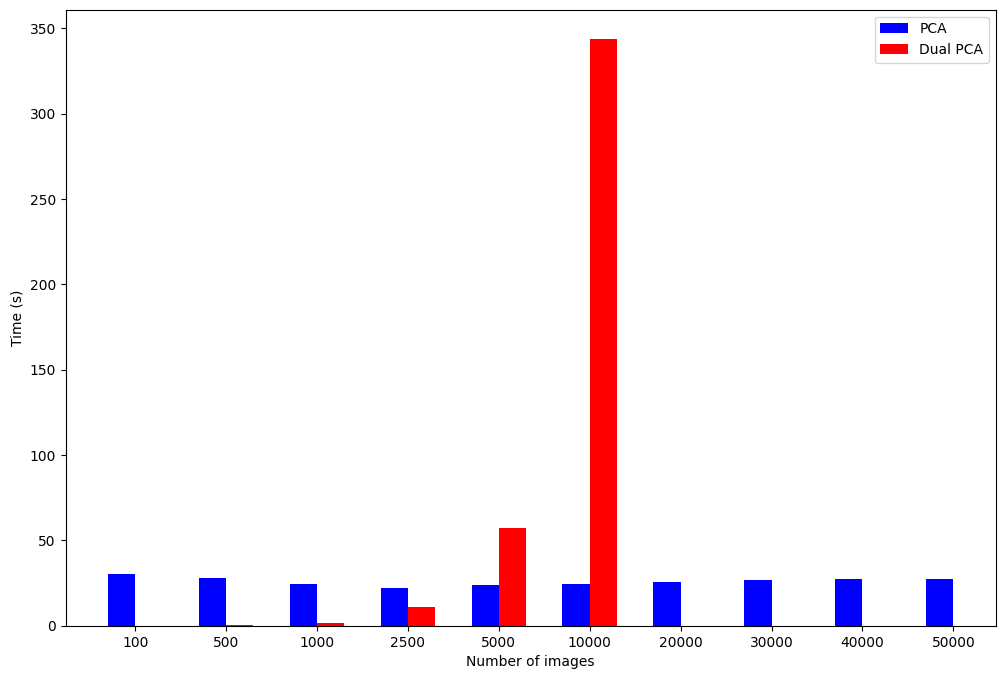

In [12]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.bar(np.arange(len(pca_time_taken))-0.15, pca_time_taken.values(), width=0.3, color='b', align='center', label="PCA")
ax.bar(np.arange(len(dpca_time_taken))+0.15, dpca_time_taken.values(), width=0.3, color='r', align='center', label="Dual PCA")
ax.set_xticks(np.arange(len(pca_time_taken)))
ax.set_xticklabels(pca_time_taken.keys())
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of images")
ax.legend()

plt.show()

We have no values for the execution time of the dual PCA algorithm at $n>10000$ because the time to execute and memory requirement increases significantly. The performance of the PCA algorithms are primarily dependent on the eigenvalue decomposition, rather than the matrix multiplication to find the covariance or Gram matrix. This means that the PCA performance is roughly constant because we are finding the decomposition for a $d \times d$ matrix, and $d$ is constant in these tests. The dual PCA execution time varies with $n$, and is significantly faster when $n < d$, as expected.

Therefore, we can conclude that dual PCA is advantageous for high-dimensional, small datasets where $n < d$. Otherwise, standard PCA will execute at about the same speed for datasets as they grow in size.

# Visualization

We will begin by visualizing the principal components and their values. Below we plot the sorted principal components and their associated eigenvalues.

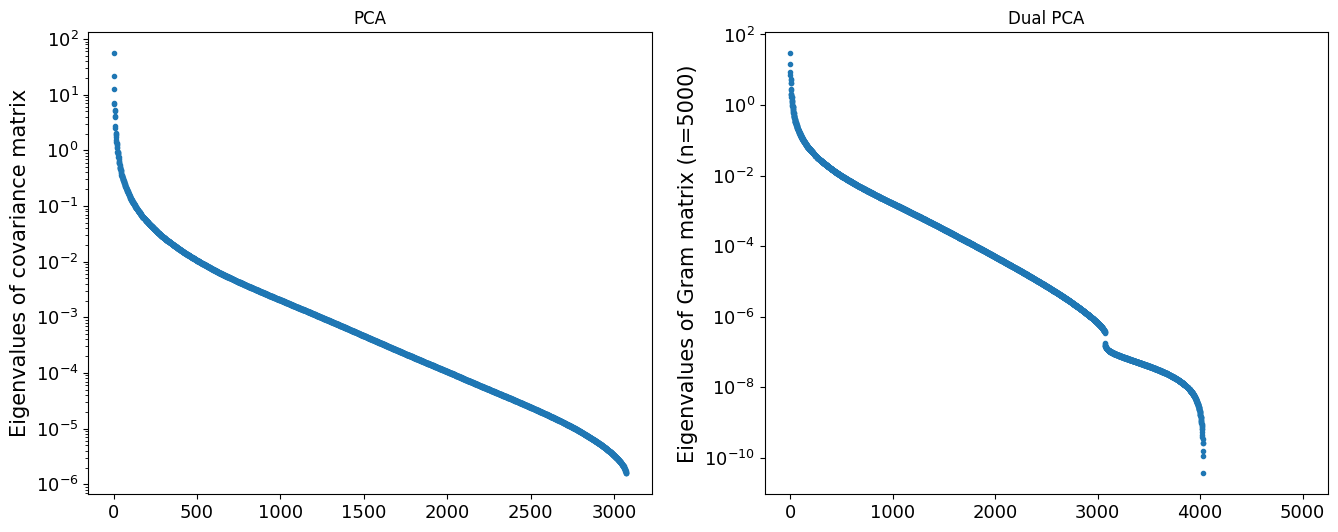

In [13]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.yscale('log')
plt.plot(range(1,len(PCvals)+1),PCvals,'.')
plt.title("PCA")
plt.ylabel('Eigenvalues of covariance matrix',fontsize=15)
plt.tick_params(labelsize=13)

plt.subplot(122)
plt.yscale('log')
plt.plot(range(1,len(DPCvals)+1),DPCvals,'.')
plt.title("Dual PCA")
plt.ylabel('Eigenvalues of Gram matrix (n=5000)',fontsize=15)
plt.tick_params(labelsize=13)

plt.show()

We can see that the first few principal components are the most "important", and that there is then a significant drop in the eigenvalues before it only decreases exponentially. On the dual PCA side, we can see that there is a sharp drop in the eigenvalues at $n=3072$, which corresponds to the dimension of the images in the dataset.

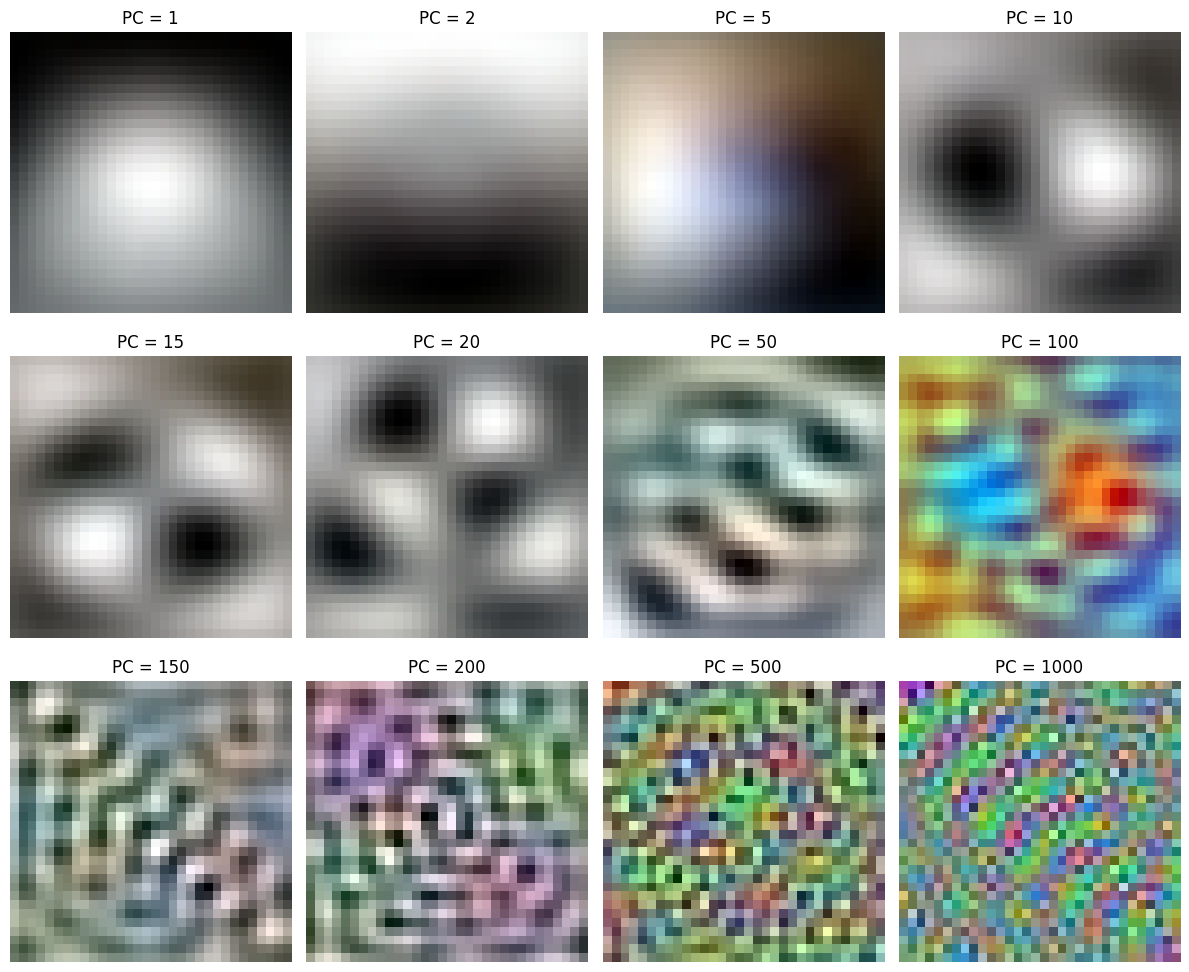

In [14]:
import cv2

pc_inds = [1,2,5,10,15,20,50,100,150,200,500,1000]

plt.figure(figsize=(12, 10))

for i in range(0, len(pc_inds)):
    plt.subplot(3, 4, i + 1)

    ind = pc_inds[i]
    
    # seperate principal component into RGB color channels and normalize
    R, Gr, B = PCvecs[:, ind - 1].reshape(3, 32, 32)
    R = (R - R.min()) / (R.max() - R.min()) * 255
    Gr = (Gr - Gr.min()) / (Gr.max() - Gr.min()) * 255
    B = (B - B.min()) / (B.max() - B.min()) * 255

    # merge RGB channels to create image
    im = cv2.merge([R, Gr, B]).astype(np.uint8)
    plt.imshow(im)

    plt.axis('off')
    plt.title('PC = {}'.format(ind))

plt.tight_layout()
plt.show()

We can visualize the principal components by reshaping the eigenvectors back to a 3-channel 32x32 image. By combining these images as specified by an encoded image, we can reconstruct an approximation of the original data.

The principal components are harder to visualize for the dual PCA method, as the eigenvectors are of dimension $\mathbb{R}^n$, not $\mathbb{R}^d$.

Below we show how to reconstruct an image using the PCA method and how the image quality varies with the number of principal components $p$ used.

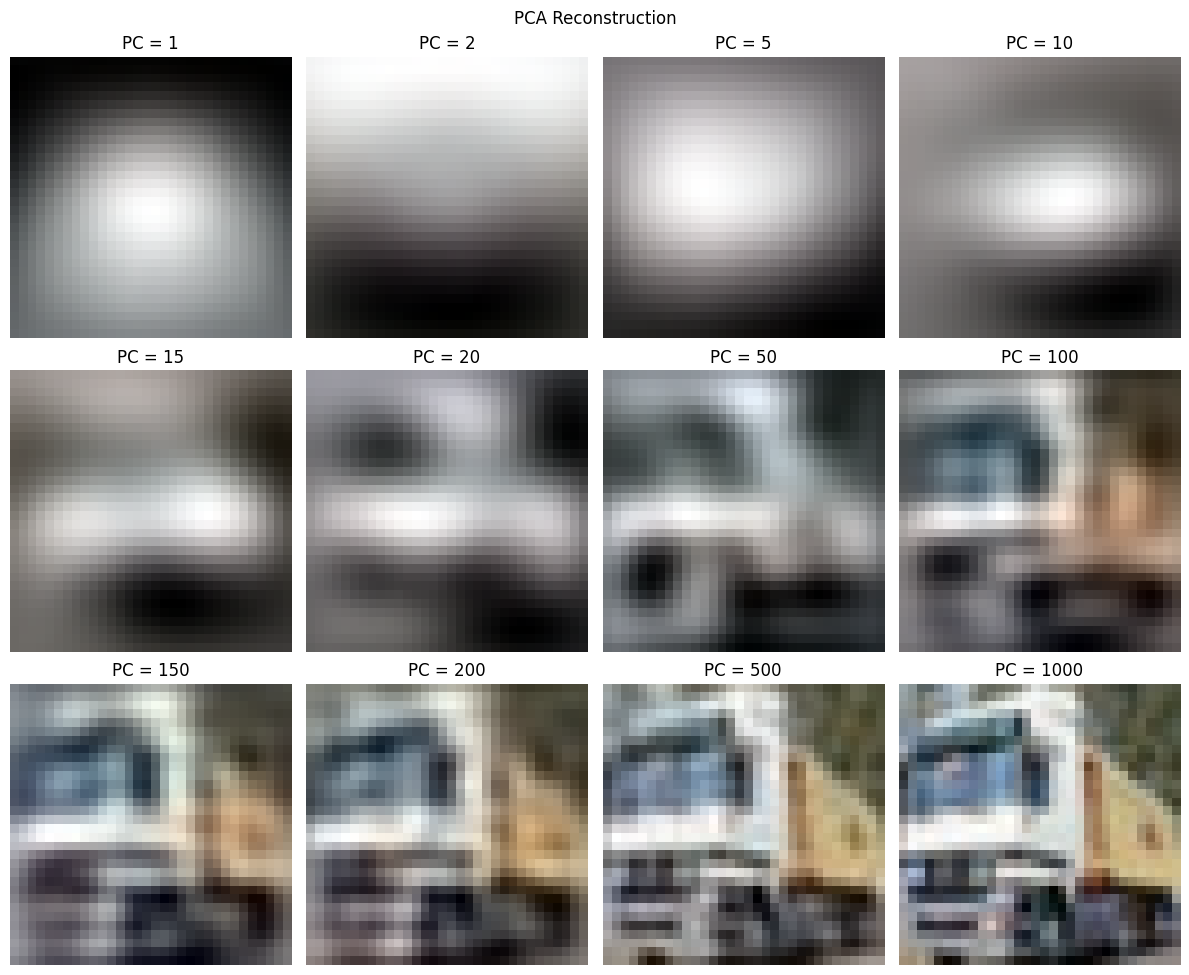

In [15]:
plt.figure(figsize=(12, 10))
plt.suptitle("PCA Reconstruction")

for i in range(0, len(pc_inds)):
    plt.subplot(3, 4, i + 1)

    ind = pc_inds[i]
    
    # reconstruct image xhat = UU^Tx
    xhat = PCvecs[:,:ind] @ PCvecs[:,:ind].T @ X[:,1]
    
    R, Gr, B = xhat.reshape(3, 32, 32)
    R = (R - R.min()) / (R.max() - R.min()) * 255
    Gr = (Gr - Gr.min()) / (Gr.max() - Gr.min()) * 255
    B = (B - B.min()) / (B.max() - B.min()) * 255

    im = cv2.merge([R, Gr, B]).astype(np.uint8)
    plt.imshow(im)
    
    plt.axis('off')
    plt.title('PC = {}'.format(ind))

plt.tight_layout()
plt.show()

Above we reconstruct the images using the PCs of the standard PCA algorithm. As the number of components used increases, the image is a closer approximation of the original image. We can also see that the first principal components have the largest impact on the final image, while at $p=1000$, the image is already close to the full image.

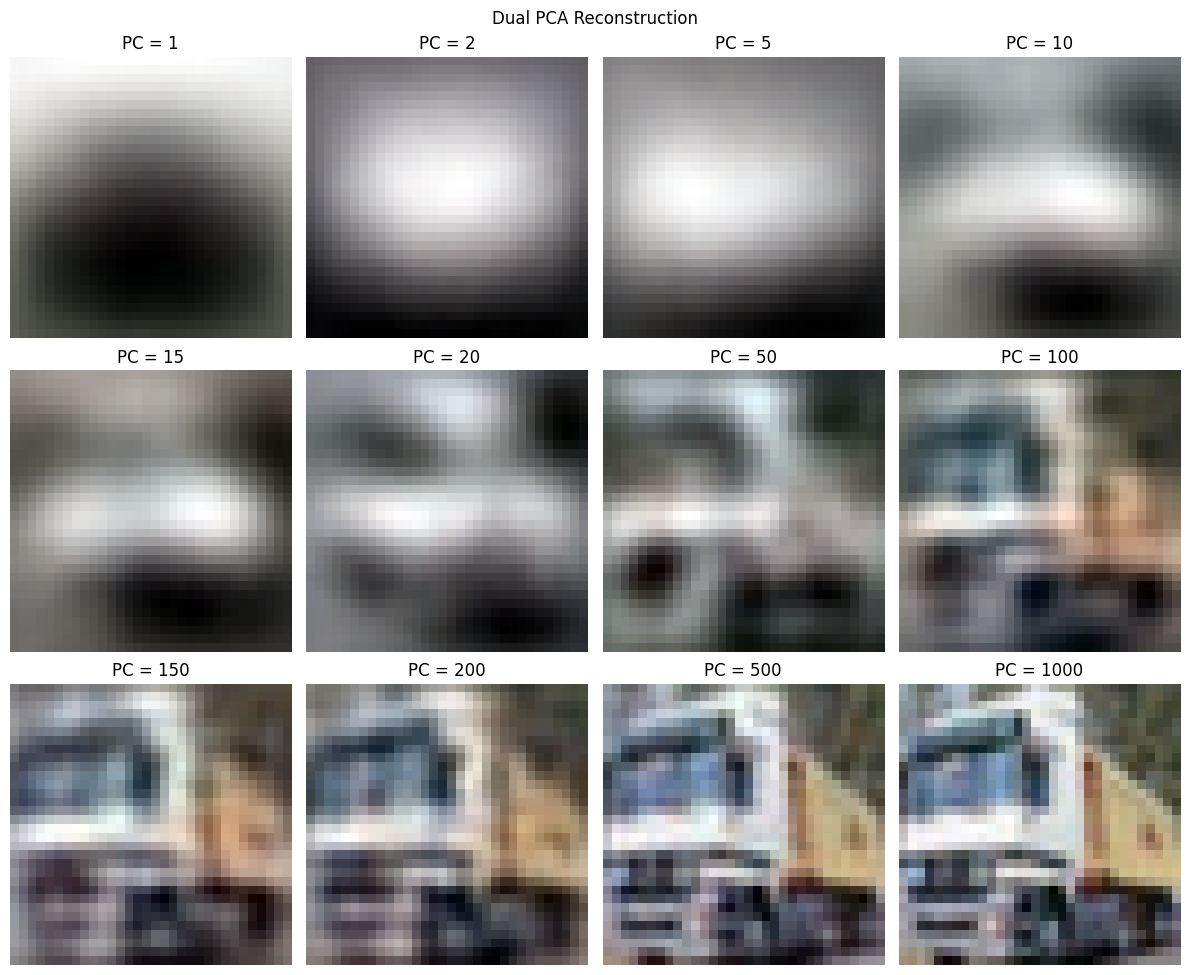

In [16]:
plt.figure(figsize=(12, 10))
plt.suptitle("Dual PCA Reconstruction")

for i in range(0, len(pc_inds)):
    plt.subplot(3, 4, i + 1)
    
    ind = pc_inds[i]
    
    # reconstruct xhat = XVS^-2V^TX^Tx
    xhat = X @ DPCvecs[:,:ind] @ np.linalg.inv(np.diag(DPCvals[:ind])) @ DPCvecs[:,:ind].T @ X.T @ X[:,1]
    
    R, Gr, B = xhat.reshape(3, 32, 32)
    R = (R - R.min()) / (R.max() - R.min()) * 255
    Gr = (Gr - Gr.min()) / (Gr.max() - Gr.min()) * 255
    B = (B - B.min()) / (B.max() - B.min()) * 255
    
    im = cv2.merge([R, Gr, B]).astype(np.uint8)
    plt.imshow(im)
    
    plt.axis('off')
    plt.title('PC = {}'.format(ind))

plt.tight_layout()
plt.show()

Above we reconstruct the image using dual PCA. We achieve similar results, with no significant difference between this and the standard PCA reconstruction.

With the principal components, we can remap the 3072-dimensional image space into two dimensions (using the first two principal components). We encode each image using the principal component vector and then plot each image in 2D.

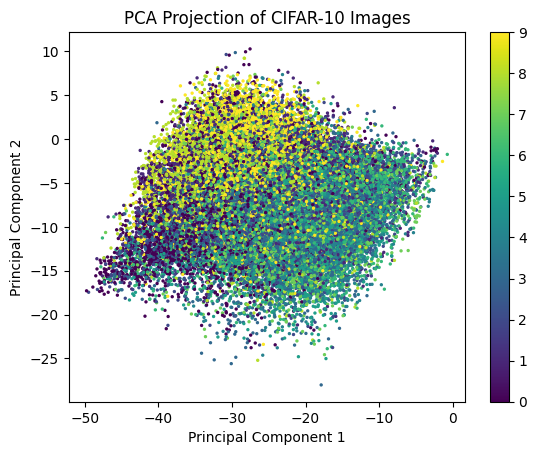

In [17]:
proj = np.dot(images.T, PCvecs[:,:2])
plt.scatter(proj[:,0], proj[:,1], c=training_data.targets, s=2)
plt.title('PCA Projection of CIFAR-10 Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In the above plot, we also colored each point using the target value of the image, which corresponds to its class (truck, plane, etc.). The grouping of the various classes shows that PCA, in capturing variance, also preserves some of the features that are the same among different images of the same class. This is true despite the fact that, as we saw earlier, the first principal components only capture very general lighting conditions of the image.

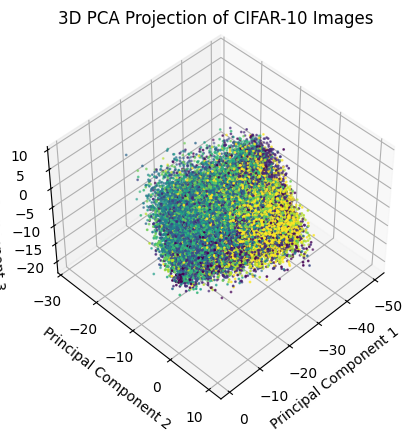

In [18]:
from mpl_toolkits.mplot3d import Axes3D

proj_3d = np.dot(images.T, PCvecs[:,:3])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(proj_3d[:,0], proj_3d[:,1], proj_3d[:,2], c=training_data.targets, s=1)
ax.set_title('3D PCA Projection of CIFAR-10 Images')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# rotate the view
ax.view_init(45, 45)

plt.show()

In the above graph, we plot the third principal component as another dimension. The strength of the grouping is marginally better than the graph with only two PCs, and we can expect subsequent dimensions to have a diminshing effectiveness in separating images of the same class into clusters.

Next, we encode the full image dataset using the first two principal components from the dual PCA algorithm.

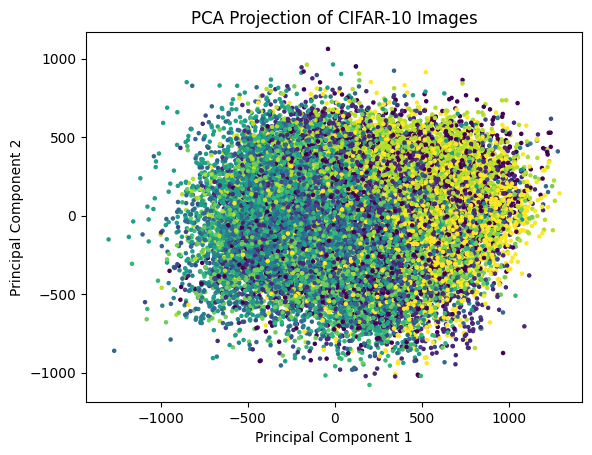

In [19]:
# encode with Xhat = S^-1V^TX^TX
proj = np.sqrt(np.linalg.inv(np.diag(DPCvals))) @ DPCvecs.T @ X.T @ images
plt.scatter(proj[0,:], proj[1,:], c=training_data.targets, s=5)
plt.title('PCA Projection of CIFAR-10 Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Although this is different than the result from the PCA plot, this is to be expected as dual PCA is only performed on the first 5000 images. We can also notice that despite being outside of the training data, the dual PCA matrix also effectively encodes images beyond the first 5000 in a way that brings similar classes to close proximity.

# Conclusion

PCA and dual PCA are both important algorithms that can be used to transform higher-dimensional data to a lower-dimensional space. PCA involves computing a $\mathbb{R}^{d\times d}$ matrix, which is expensive for high-dimensional data, such as images. By using dual PCA when $d > n$, we can save on computation by computing a $\mathbb{R}^{n\times n}$ matrix instead. As seen with CIFAR-10 above, dual PCA can be highly effective as $d$ grows relative to $n$, as a 4k image would already have over 24 million dimensions.